In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(8,5)})
matplotlib.rc_file_defaults()

In [2]:
df = pd.read_csv("../../data/dataset_v3.csv")

In [3]:
df.head()

,user_id,country,source,platform,device_family,event_1,event_2,revenue
0,44023fc9,it,Organic,iOS,Apple iPhone,28,1,0.097079
1,990ce89e,de,Organic,Android,Samsung Galaxy Phone,51,5,0.233669
2,0c103f51,pt,Organic,iOS,Apple iPhone,647,157,1.630575
3,ab2de453,pt,Organic,iOS,Apple iPad,35,0,0.084876
4,45c0aca3,fr,Non-Organic,Android,Samsung Galaxy Phone,0,0,0.000000


# Datos generales

In [4]:
df.shape

(30000, 8)

In [5]:
df.describe()

,event_1,event_2,revenue
count,30000.000000,30000.000000,3.000000e+04
mean,50.047000,3.604467,7.710355e+02
std,116.113945,16.643703,2.484142e+04
min,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000e+00
50%,4.000000,0.000000,9.683000e-03
75%,49.000000,1.000000,1.131700e-01
max,2694.000000,643.000000,2.082207e+06


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        30000 non-null  object 
 1   country        30000 non-null  object 
 2   source         27243 non-null  object 
 3   platform       30000 non-null  object 
 4   device_family  30000 non-null  object 
 5   event_1        30000 non-null  int64  
 6   event_2        30000 non-null  int64  
 7   revenue        30000 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 1.8+ MB


## Con estos paso ya podemos identificar dos problemas a tratar:
    - source es categórico y tiene nulos. 
    - La distribución de datos de eventos no son directamente comparables por se manejan a diferentes escalas y sus distribuciones tienen más peso en el tail

# Cantidad de datos distintos por columna

### Usuarios

In [7]:
df.user_id.nunique()

30000

### Países

In [8]:
df.country.nunique()

100

In [9]:
df[['user_id','country']].groupby(['country']).count().reset_index().sort_values(by=['user_id'], ascending=False)

,country,user_id
29,es,20002
31,fr,5164
62,mx,936
4,ar,693
47,it,372
...,...,...
56,mc,1
72,pf,1
58,ml,1
60,mt,1


Hay un enorme de desbalanceo entre países. Visualicemos para entender mejor esto.

In [10]:
df[['user_id','country']].groupby(['country']).count().reset_index()\
    .sort_values(by=['user_id'], ascending=False).describe(percentiles=[.3,.5,.75,.85,.9,.95,.99])

,user_id
count,100.000000
mean,300.000000
std,2059.092033
min,1.000000
30%,1.000000
50%,4.500000
75%,26.250000
85%,86.150000
90%,158.400000
95%,353.950000


In [11]:
df_countries = df.groupby(['country']).size().rename('cantidad').reset_index()

In [12]:
# Agrupo países según cantidad, dado el gran desbalanceo.
df_countries['paises'] =  np.where(df_countries['cantidad'] >= 87, df_countries['country'], 'Otros países')

<AxesSubplot:xlabel='paises'>

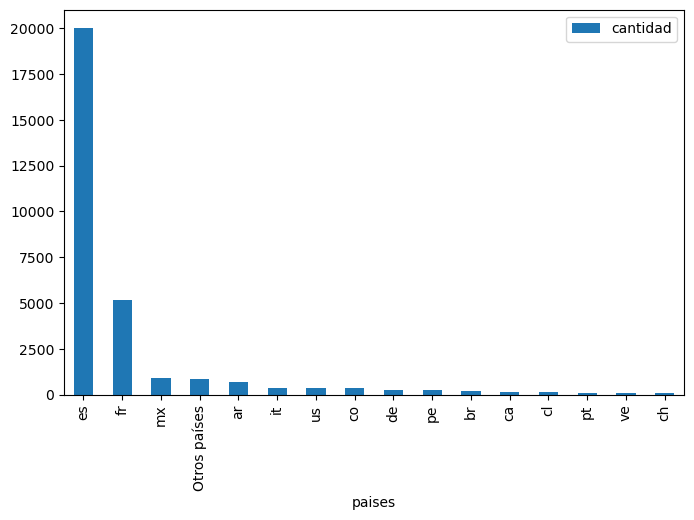

In [13]:
df_countries.groupby(['paises']).sum('cantidad').reset_index()\
    .sort_values(by=['cantidad'], ascending=False).plot.bar(x='paises', rot=90, figsize=(8,5))

Veamos el revenue acumulado y promedio por país

In [14]:
df_countries = df_countries.merge(df.groupby(['country'])['revenue'].agg(['sum']).reset_index(),
                                 on='country',
                                 how='inner').groupby('paises').agg({'cantidad': 'sum', 'sum': 'sum'}).reset_index()

In [15]:
df_countries['prom'] = df_countries['sum']/df_countries['cantidad']

In [16]:
df_countries.head(5)

,paises,cantidad,sum,prom
0,Otros países,867,344737.621002,397.621247
1,ar,693,473994.147401,683.974239
2,br,180,9257.967149,51.433151
3,ca,156,34.634402,0.222015
4,ch,87,619838.148013,7124.576414


<ipython-input-17-030e466167d7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=aux.paises, rotation=90)


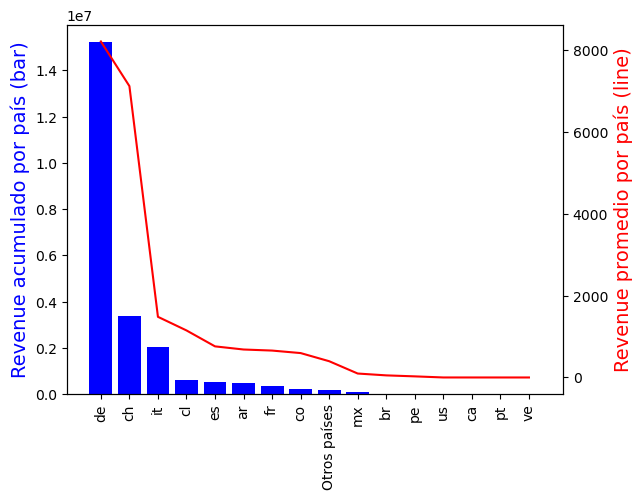

In [17]:
# Para crear subplots
fig,ax = plt.subplots()
# Definimos el plot
ax2 = ax.twinx()

aux = df_countries[['paises', 'sum']] \
    .sort_values(by=['sum'], ascending=False)
ax.bar(aux.paises, aux['sum'], color = "blue")
ax.set_xticklabels(labels=aux.paises, rotation=90)
ax.set_ylabel("Revenue acumulado por país (bar)",color="blue", fontsize=14)

aux2 = df_countries[['paises', 'prom']] \
    .sort_values(by=['prom'], ascending=False)
ax2.plot(aux2.paises, aux2.prom, color = "red")
ax2.set_ylabel("Revenue promedio por país (line)",color="red",fontsize=14)

plt.show()

Podemos ver que los revenues más altos no vienen de los países en los que se tienen más usuarios.
A su vez, los países con menos de 87 usuarios (otros países) tienen muy poca cantidad de usuarios como tomarlos en la muestra entendiendo que el revenue cambia según el país.
Por tanto, para este análisis se utilizará una feature que identifique el país pero agrupando los países de pocos usuarios como así también features que caractericen al país, como si tiene muchos usuarios, promedio de revenue por usuario de ese país, etc.

### Source: orgánicos vs no orgánicos

In [18]:
df.source.nunique()

2

In [19]:
df.source.value_counts()

Organic        20009
Non-Organic     7234
Name: source, dtype: int64

In [20]:
df_sources = df[['source']].copy()
df_sources['source_category'] = np.where(~df_sources['source'].isin(['Non-Organic', 'Organic']),
                                         'Desconocido', df_sources['source'])
df_sources = df_sources.groupby(['source_category']).size().rename('cantidad').reset_index()

In [21]:
df_sources

,source_category,cantidad
0,Desconocido,2757
1,Non-Organic,7234
2,Organic,20009


Si bien hay un pequeño desbalanceo de 1 a 3, en principio lo tomaremos sin hacer técnicas de balanceo.
Por otro lado existen nulos por lo que se añade la categoría 'desconocido', ya que no es una cantidad despreciable y se tiene el valor del resto de las columnas (no existe otra columna con nulos)

### Platform

In [22]:
df.platform.nunique()

4

In [23]:
df.platform.value_counts()

Android    19880
iOS         8606
android     1070
ios          444
Name: platform, dtype: int64

Se aprecia la falta de estadarización en los valores posibles que son dos: Android e IOs. Por tanto llevaremos todo a minúsculas para resolver esto.

In [24]:
df.platform = df.platform.str.lower()

In [25]:
df.platform.value_counts()

android    20950
ios         9050
Name: platform, dtype: int64

Si bien existe un desbalanceo de clases a razón 1:2, no haremos ninguna técnica de balanceo dada que la razón no lo amerita por el momento.

### Device family

In [26]:
df.device_family.nunique()

1194

In [27]:
df_devices = df[['device_family', 'user_id']].copy()

In [28]:
df_devices.groupby(['device_family']).count().reset_index().describe(percentiles=[.3,.5,.75,.9,.95,.99,.999])

,user_id
count,1194.000000
mean,25.125628
std,277.290778
min,1.000000
30%,1.000000
50%,2.000000
75%,4.000000
90%,17.000000
95%,39.350000
99%,217.800000


In [29]:
df_devices = df_devices.groupby(['device_family']).size().rename('cantidad').reset_index()
df_devices.sort_values(by=['cantidad'], ascending=False).head()

,device_family,cantidad
35,Apple iPhone,7118
568,Samsung Galaxy Phone,5040
309,Huawei Phone,2535
765,Xiaomi Phone,2288
30,Apple iPad,1446


In [30]:
# Agrupo devices según cantidad, dado el gran desbalanceo.
df_devices['device_category'] =  np.where(df_devices['cantidad'] >= 260, df_devices['device_family'], 'Otros devices')

In [31]:
df_devices.groupby('device_category').sum('cantidad').reset_index()\
        .sort_values(by=['cantidad'], ascending=False)

,device_category,cantidad
3,Otros devices,8700
1,Apple iPhone,7118
8,Samsung Galaxy Phone,5040
2,Huawei Phone,2535
10,Xiaomi Phone,2288
0,Apple iPad,1446
9,Samsung Galaxy Tab,1248
6,Redmi Xiaomi Redmi Note 9 Pro,373
11,xiaomi Xiaomi Redmi Note 8T,350
4,Redmi Xiaomi M2003J15SC,322


In [32]:
# Agrupamos mismas marcas en conjunto
# Condiciones de agrupamiento 
conditions = [
    (df_devices.device_category.str.lower().str.contains('samsung')),
    (df_devices.device_category.str.lower().str.contains('apple')), 
    (df_devices.device_category.str.lower().str.contains('huawei')), 
    (df_devices.device_category.str.lower().str.contains('xiaomi')),
    (df_devices.device_category.str.lower().str.contains('otros devices'))
    ]

# Valores a asignar por condición
values = ['samsung', 'apple', 'huawei', 'xiaomi', 'otros devices']

# Nueva columna con la categoría de dispositivo
df_devices['device_category'] = np.select(conditions, values)

In [33]:
df_devices.groupby('device_category').sum('cantidad').reset_index()\
        .sort_values(by=['cantidad'], ascending=False)

,device_category,cantidad
2,otros devices,8700
0,apple,8564
3,samsung,6605
4,xiaomi,3596
1,huawei,2535


### Eventos

In [34]:
df[['event_1', 'event_2']].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.75,.85,.9,.99,.999])

,event_1,event_2
count,30000.000000,30000.000000
mean,50.047000,3.604467
std,116.113945,16.643703
min,0.000000,0.000000
10%,0.000000,0.000000
20%,0.000000,0.000000
30%,0.000000,0.000000
40%,0.000000,0.000000
50%,4.000000,0.000000
60%,14.000000,0.000000


<AxesSubplot:>

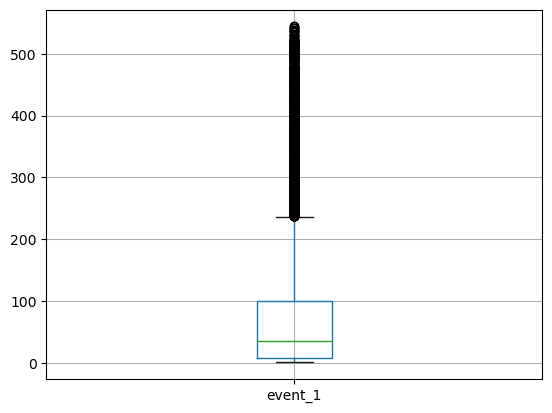

In [35]:
df[['event_1']][
    (df.event_1 < 545)
    & (df.event_1 > 0)
].boxplot()

<AxesSubplot:>

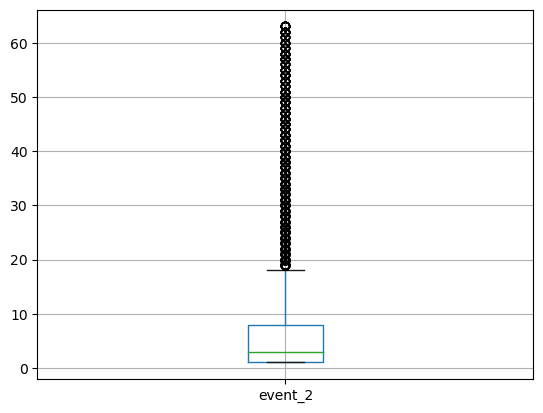

In [36]:
df[['event_2']][
    (df.event_2 < 64)
    & (df.event_2 > 0)
].boxplot()

Se tienen outliers en ambos eventos aunque están a distinta escala.
También se aprecia que para aproximadamente el 50% de los datos, el número de eventos es 0.
Dada lo pequeño del dataset y la imposibilidad de investigar el origen de estas anomalías para su correcto tratamiento crearemos una nueva variable que indique si existen o no eventos (por la cantidad de 0) y además borraremos los outliers a partir del cuantil 99.

In [37]:
df_eventos = df[['event_1', 'event_2']][
    (df['event_1'] < 545)
    & (df['event_2'] < 64)
].copy()
df_eventos['has_event_1'] = np.where(df_eventos['event_1'] > 0, 1, 0)
df_eventos['has_event_2'] = np.where(df_eventos['event_2'] > 0, 1, 0)

In [38]:
df_eventos.head()

,event_1,event_2,has_event_1,has_event_2
0,28,1,1,1
1,51,5,1,1
3,35,0,1,0
4,0,0,0,0
5,139,4,1,1


In [39]:
df_eventos.shape

(29464, 4)

### Revenue

In [40]:
df[['revenue']].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.75,.85,.9,.99,.999])

,revenue
count,3.000000e+04
mean,7.710355e+02
std,2.484142e+04
min,0.000000e+00
10%,0.000000e+00
20%,0.000000e+00
30%,0.000000e+00
40%,1.789200e-03
50%,9.683000e-03
60%,3.237440e-02


array([[<AxesSubplot:title={'center':'revenue'}>]], dtype=object)

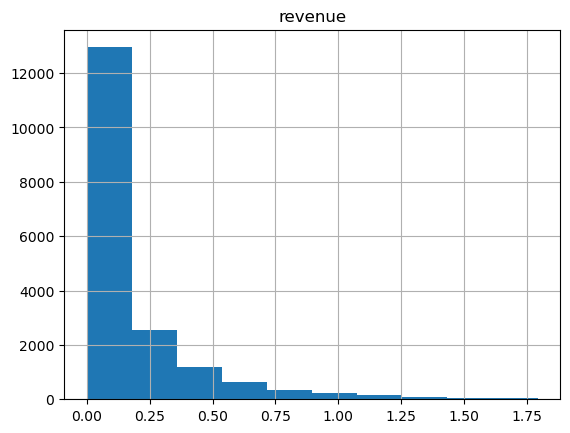

In [41]:
df[['revenue']][
    (df['revenue'] > 0)
    & (df['revenue'] < 1.8)
].hist()

<AxesSubplot:>

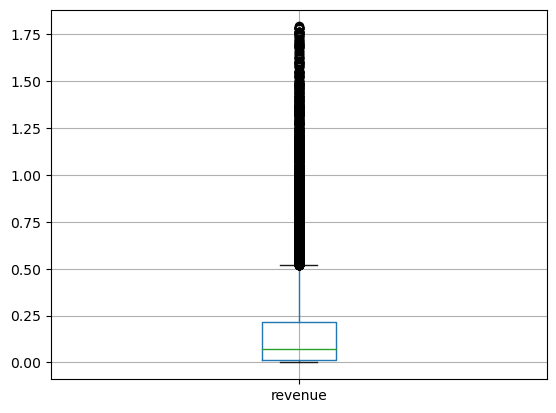

In [42]:
df[['revenue']][
    (df['revenue'] > 0)
    & (df['revenue'] < 1.8)
].boxplot()

En el caso del revenue, al ser el target, no es afectado por cuestiones de escala a la hora de optimizar la función de costos, por lo que en principio no es necesario escalar a pesar de su distribución. 
Sin embargo, a la hora de medir performance, sería de mucha ayuda segmentar los revenue según categoría (por ejemplo: bajo, medio y alto) para medir su eficiencia según el rango de revenue que se obtendría. De esa manera no sólo haríamos predicción del revenue, sino que también daríamos más peso a predecir mejor a las de algún rango que sea más importante para el negocio.
Por otro lado, se observa un 30% de la población con revenue 0, por lo que se propone en una próxima iteración hacer sumsampling sobre esto, dado el ruido que podría hacer sobre el modelo.